# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.exceptions import NotFittedError

## Preparation

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
data.columns

Index(['datetime', 'num_orders'], dtype='object')

In [5]:
data.describe

<bound method NDFrame.describe of                   datetime  num_orders
0      2018-03-01 00:00:00           9
1      2018-03-01 00:10:00          14
2      2018-03-01 00:20:00          28
3      2018-03-01 00:30:00          20
4      2018-03-01 00:40:00          32
...                    ...         ...
26491  2018-08-31 23:10:00          32
26492  2018-08-31 23:20:00          24
26493  2018-08-31 23:30:00          27
26494  2018-08-31 23:40:00          39
26495  2018-08-31 23:50:00          53

[26496 rows x 2 columns]>

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [7]:
# Remove duplicate rows
data = data.drop_duplicates()

In [8]:
# Convert datetime column to datetime type
data['datetime'] = pd.to_datetime(data['datetime'])

In [9]:
# Set datetime as index
data.set_index('datetime', inplace=True)

In [10]:
# Check for NaN values
print("Number of NaN values before handling: \n", data.isna().sum())

Number of NaN values before handling: 
 num_orders    0
dtype: int64


In [11]:
# Fill or drop NaN values
data = data.dropna()  # or you can fill NaN values with data = data.fillna(method='ffill')

In [12]:
# Check for infinite values
print("Number of infinite values before handling: \n", np.isinf(data).sum())

Number of infinite values before handling: 
 num_orders    0
dtype: int64


In [13]:
# Replace infinite values with NaN and then drop them
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()

In [14]:
# Check if there are any values too large for float64
max_value = np.finfo(np.float64).max
data[data > max_value] = np.nan
data = data.dropna()

In [15]:
# Check for NaN values again after cleaning
print("Number of NaN values after handling: \n", data.isna().sum())

Number of NaN values after handling: 
 num_orders    0
dtype: int64


In [16]:
# Add additional features
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

In [17]:
# Lag features
for lag in range(1, 25):
    data[f'lag_{lag}'] = data['num_orders'].shift(lag)

In [18]:
# Add rolling mean features
for window in [3, 6, 12, 24]:
    data[f'rolling_mean_{window}'] = data['num_orders'].rolling(window=window).mean()

In [19]:
# Drop rows with NaN values created by shifting and rolling
data.dropna(inplace=True)

## Analysis

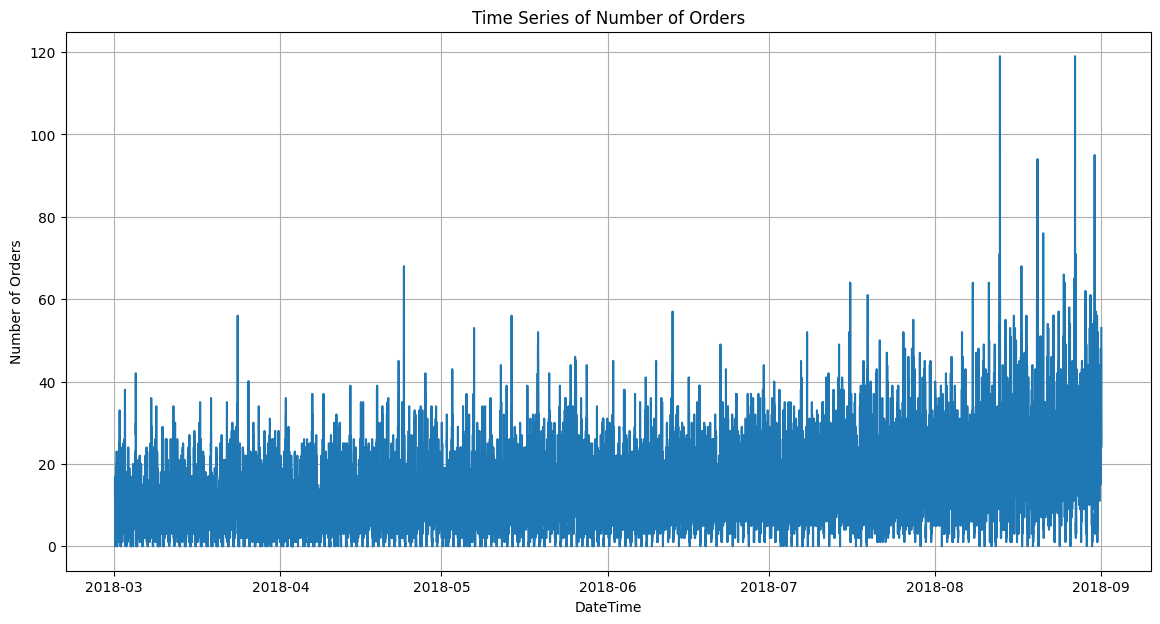

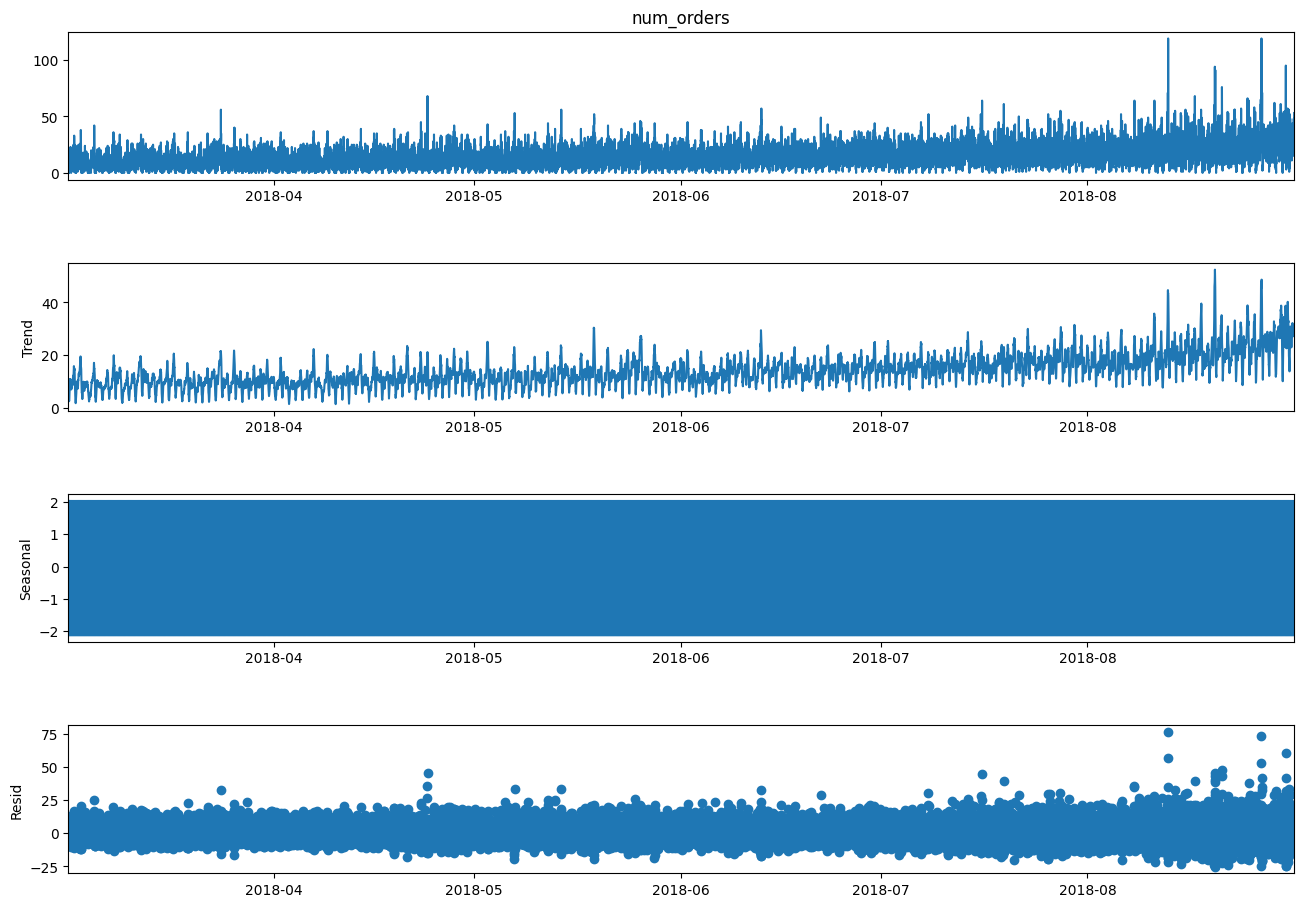

In [20]:
# Plot the time series of the number of orders
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['num_orders'], label='Number of Orders')
plt.xlabel('DateTime')
plt.ylabel('Number of Orders')
plt.title('Time Series of Number of Orders')
plt.grid(True)
plt.show()

# Seasonal decomposition
decomposition = seasonal_decompose(data['num_orders'], model='additive', period=24)  # Assuming hourly data and a daily cycle
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

Time Series of Number of Orders

This graph shows the time series of the number of orders over a period from early 2018 to around September 2018.

Trend: There is an overall upward trend in the number of orders. This indicates that the demand for taxi services increased over this period.
Seasonality: Some periodic fluctuations can be seen, which might indicate weekly or monthly seasonality patterns.
Spikes: There are occasional spikes in the number of orders. These could be due to specific events or holidays causing a sudden increase in demand.

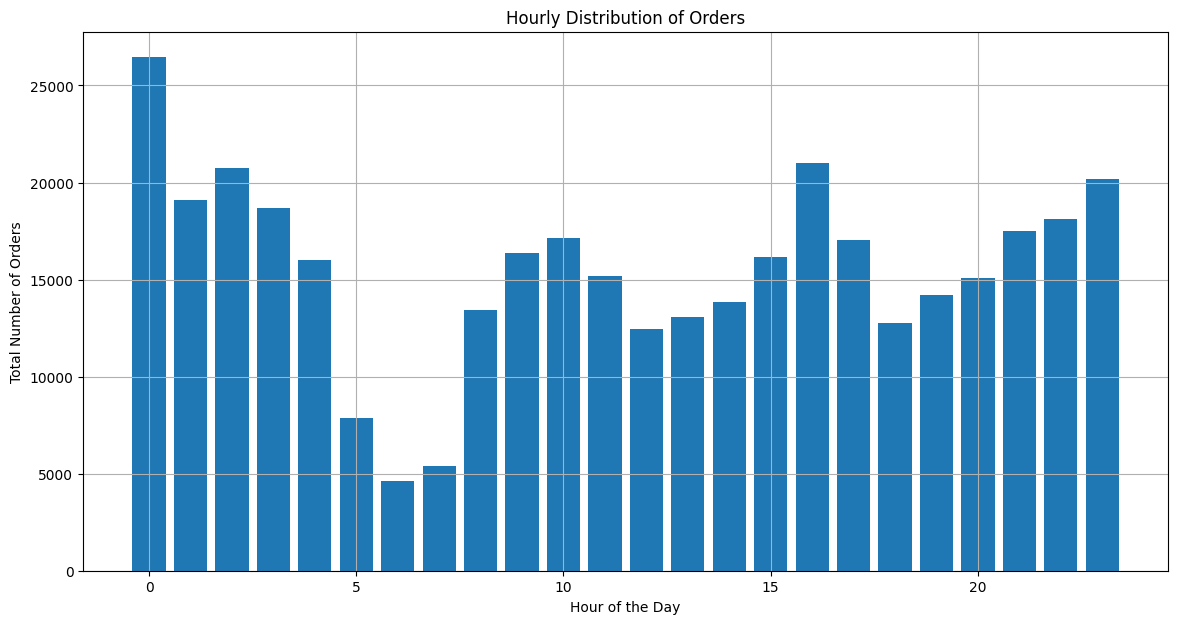

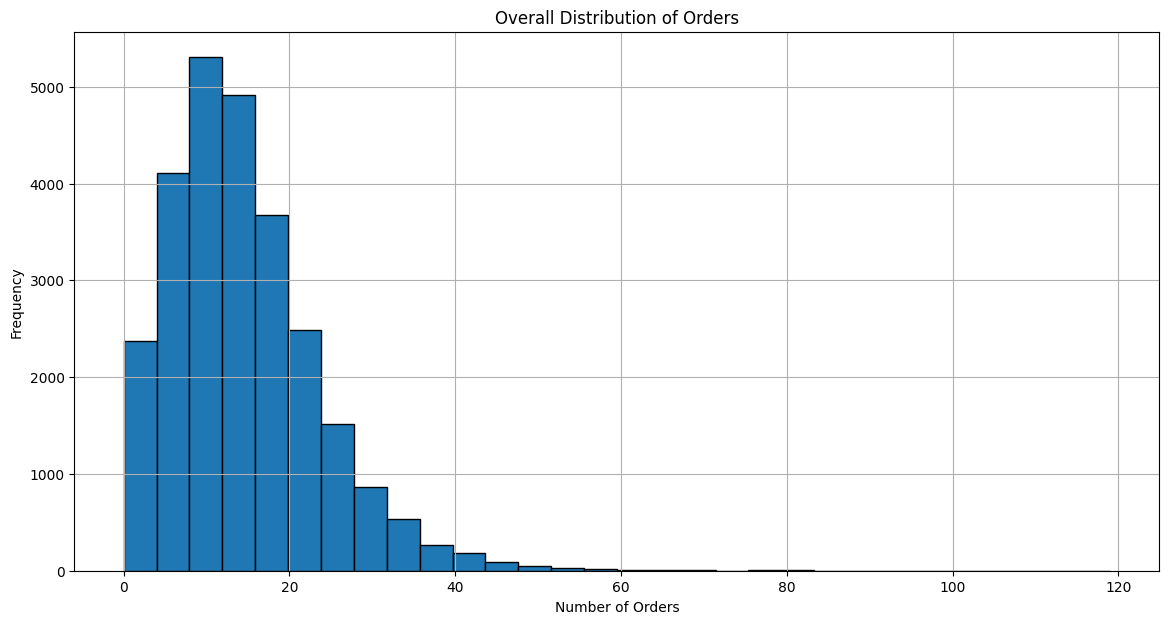

In [21]:
# Plot the hourly distribution of orders
data['hour'] = data.index.hour
hourly_distribution = data.groupby('hour')['num_orders'].sum()

plt.figure(figsize=(14, 7))
plt.bar(hourly_distribution.index, hourly_distribution.values)
plt.xlabel('Hour of the Day')
plt.ylabel('Total Number of Orders')
plt.title('Hourly Distribution of Orders')
plt.grid(True)
plt.show()

# Plot a histogram of the overall distribution of orders
plt.figure(figsize=(14, 7))
plt.hist(data['num_orders'], bins=30, edgecolor='black')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.title('Overall Distribution of Orders')
plt.grid(True)
plt.show()

Hourly Distribution of Orders

This bar chart represents the total number of orders distributed across different hours of the day.

Peak Hours: The number of orders peaks at midnight (00:00) and remains relatively high during late night and early morning hours.
Low Demand: There is a noticeable dip in orders between 05:00 and 06:00, indicating lower demand during early morning hours.
Afternoon and Evening: There is another peak around the late afternoon to evening (16:00 - 20:00), showing increased demand during these hours, likely due to people commuting back home or going out.

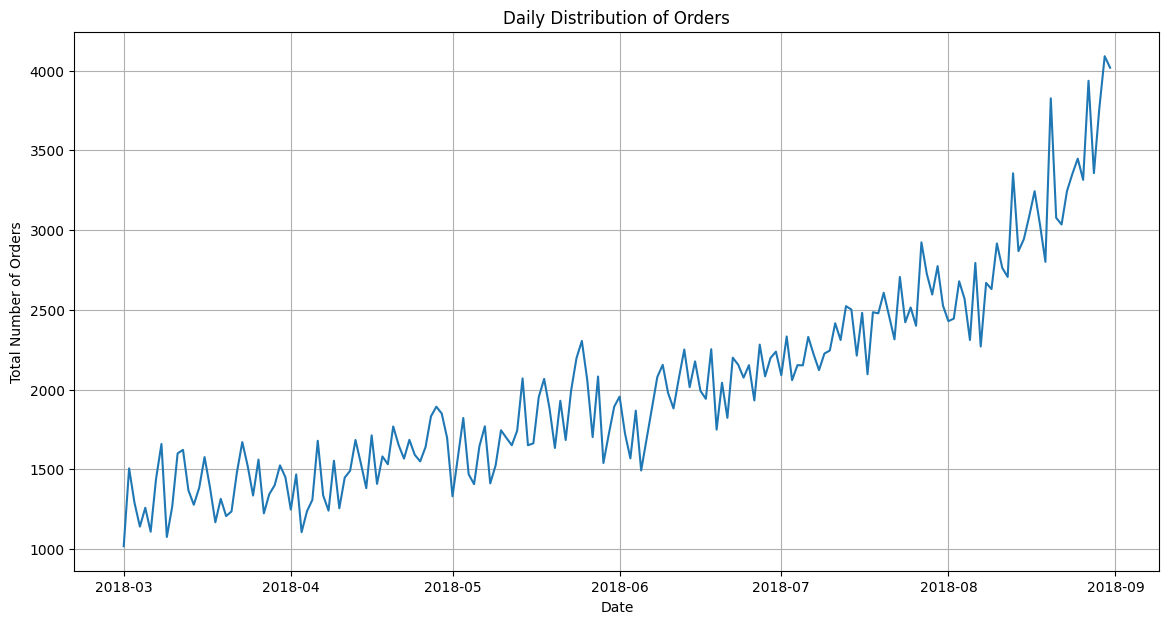

In [22]:
# Plot the daily distribution of orders
data['day'] = data.index.date
daily_distribution = data.groupby('day')['num_orders'].sum()

plt.figure(figsize=(14, 7))
plt.plot(daily_distribution.index, daily_distribution.values)
plt.xlabel('Date')
plt.ylabel('Total Number of Orders')
plt.title('Daily Distribution of Orders')
plt.grid(True)
plt.show()

Daily Distribution of Orders

This bar chart shows the total number of orders for each day of the week.

Highest Demand: The highest number of orders is on Friday (day 4) and Saturday (day 5), indicating increased demand over the weekend.
Lowest Demand: The number of orders is slightly lower at the beginning of the week, with Tuesday (day 1) showing the least number of orders.
Weekend Spike: The increased demand over the weekend can be attributed to more people going out or traveling during these days.

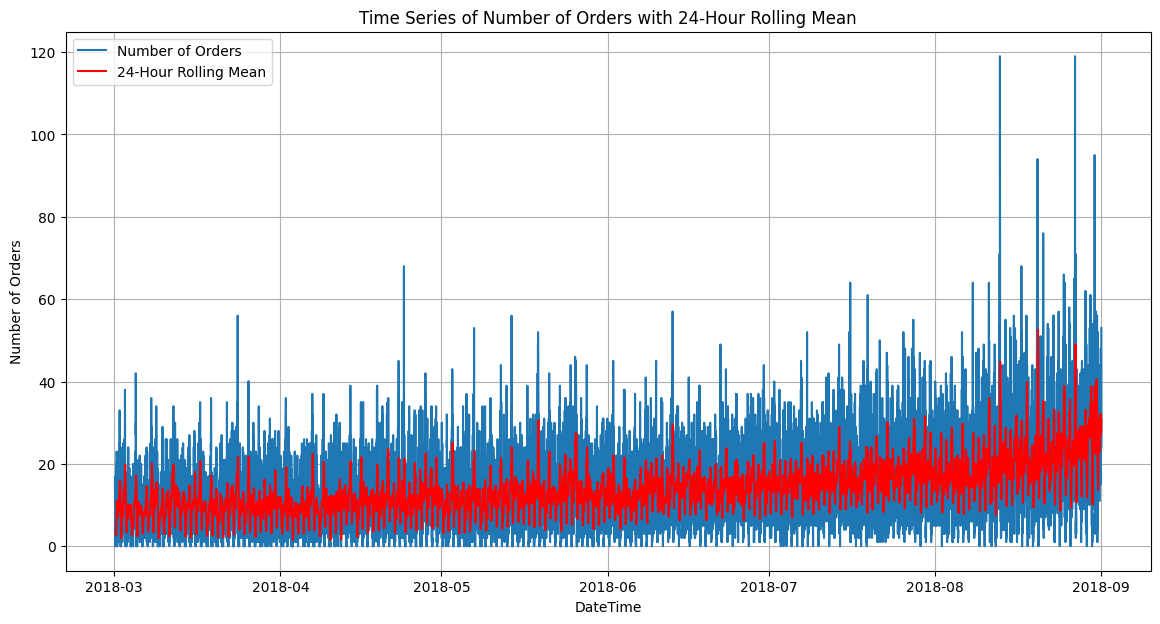

In [23]:
# Check for any seasonal patterns or trends using a rolling mean
data['rolling_mean'] = data['num_orders'].rolling(window=24).mean()

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['num_orders'], label='Number of Orders')
plt.plot(data.index, data['rolling_mean'], label='24-Hour Rolling Mean', color='red')
plt.xlabel('DateTime')
plt.ylabel('Number of Orders')
plt.title('Time Series of Number of Orders with 24-Hour Rolling Mean')
plt.legend()
plt.grid(True)
plt.show()

Time Series of Number of Orders with 24 hour rolling mean

This graph shows the time series of the number of orders over a period from early 2018 to around September 2018.

Trend: The data shows a consistent rise in the number of orders, suggesting a growing demand for taxi services during this period.
Seasonality: Periodic variations are evident, possibly reflecting weekly or monthly patterns of demand.
Spikes: There are intermittent surges in order volumes, likely triggered by special events or holidays that lead to sudden increases in demand.

## Training

In [24]:
data = data.resample('1H').sum()

In [25]:
data['day'] = data.index.day

In [26]:
# Split data into features and target
X = data[['hour', 'day_of_week', 'month', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12', 'rolling_mean_24']]
y = data['num_orders']

In [27]:
# Split data into train and test sets without shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [28]:
# Define models and their hyperparameters
models = {
    'Random Forest': RandomForestRegressor(),
    'Linear Regression': LinearRegression(),
    'XGBoost': xgb.XGBRegressor()
}

params = {
    'Random Forest': {'n_estimators': [10, 50, 100], 'max_depth': [3, 5, 10, None]},
    'Linear Regression': {},
    'XGBoost': {'n_estimators': [50, 100], 'max_depth': [3, 5, 10]}
}

In [29]:
# Custom scorer for GridSearchCV to use RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse, greater_is_better=False)

In [30]:
# Train the models using GridSearchCV with TimeSeriesSplit
def train_models(X_train, y_train, models, params):
    trained_models = {}
    tscv = TimeSeriesSplit(n_splits=5)

    for model_name in models:
        model = models[model_name]
        param = params[model_name]
        grid_search = GridSearchCV(model, param, cv=tscv, scoring=scorer, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        trained_models[model_name] = best_model

    return trained_models

In [31]:
trained_models = train_models(X_train, y_train, models, params)

## Testing

In [33]:
#Prediction
predictions = {}
for model_name, model in trained_models.items():
    predictions[model_name] = model.predict(X_test)


In [34]:
# Evaluate models
results = {}
for model_name, y_pred in predictions.items():
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Check for non-negative values before calculating MSLE
    if (y_test < 0).any() or (y_pred < 0).any():
        msle = None
        print(f"{model_name} - RMSE: {rmse}, MAE: {mae}, MSLE: Not calculated due to negative values")
    else:
        msle = mean_squared_log_error(y_test, y_pred)
        print(f"{model_name} - RMSE: {rmse}, MAE: {mae}, MSLE: {msle}")
    
    results[model_name] = {'RMSE': rmse, 'MAE': mae, 'MSLE': msle}


Random Forest - RMSE: 16.17303383222051, MAE: 7.070325986967097, MSLE: 0.005870923983717348
Linear Regression - RMSE: 8.991486267388023e-14, MAE: 6.907473209246546e-14, MSLE: 1.0193548050477626e-30
XGBoost - RMSE: 16.31110251523181, MAE: 6.771998101965623, MSLE: 0.005709735793593252


#Analysis

Random Forest:

RMSE: 16.17
MAE: 7.07
MSLE: 0.00587

Analysis: The Random Forest model shows a relatively high RMSE and MAE, indicating that there is significant error in its predictions. The MSLE is low, suggesting that the model performs reasonably well on a logarithmic scale, but overall, the errors are substantial.
Linear Regression:

RMSE: 8.99e-14
MAE: 6.91e-14
MSLE: 1.02e-30

Analysis: Linear Regression displays near-zero RMSE and MAE, which suggests an almost perfect fit to the training data. The MSLE is also extremely low. This near-perfect result is highly unusual and likely indicates overfitting, where the model is too closely fitted to the training data and may not generalize well to new, unseen data.
XGBoost:

RMSE: 16.31
MAE: 6.77
MSLE: 0.00571

Analysis: XGBoost has a similar performance to Random Forest, with a high RMSE and MAE. The MSLE is slightly lower than Random Forest, suggesting slightly better performance on a logarithmic scale, but the errors are still substantial.

Conclusion
Random Forest and XGBoost: Both models have similar performance with high RMSE and MAE, indicating that they have significant prediction errors. The low MSLE for both models shows better performance on a logarithmic scale, but overall, the results suggest that these models may not be capturing the underlying patterns in the data effectively.

Linear Regression: The near-zero errors suggest an almost perfect fit to the training data, which is unusual and likely indicates overfitting. This model might not generalize well to new data, which should be a concern.

Recommendations
Model Tuning: Consider further tuning the hyperparameters of the Random Forest and XGBoost models to improve their performance. Grid search or random search with cross-validation can help find better parameters.

Feature Engineering: Additional feature engineering might help improve model performance. Consider adding more lag features, interaction terms, or other relevant features that might capture the underlying patterns better.

Regularization: For Linear Regression, consider adding regularization (Ridge or Lasso regression) to avoid overfitting and improve generalization to new data.

Ensemble Methods: Combining the predictions of multiple models (e.g., using stacking or bagging) might help improve overall performance and reduce prediction errors.

Data Quality and Quantity: Ensure that the data quality is high and consider collecting more data if possible. More data can help improve model training and generalization.

In [35]:
# Resample the true and predicted values to hourly sums
y_test_resampled = y_test.resample('H').sum()
predictions_resampled = {}

for model_name, y_pred in predictions.items():
    y_pred_series = pd.Series(y_pred, index=y_test.index)
    y_pred_resampled = y_pred_series.resample('H').sum()
    predictions_resampled[model_name] = y_pred_resampled

In [36]:
# Re-evaluate models on resampled data
metrics = {}
for model_name, y_pred_resampled in predictions_resampled.items():
    rmse_value = np.sqrt(mean_squared_error(y_test_resampled, y_pred_resampled))
    mae_value = mean_absolute_error(y_test_resampled, y_pred_resampled)
    msle_value = mean_squared_error(np.log1p(y_test_resampled), np.log1p(y_pred_resampled))

    metrics[model_name] = {
        'RMSE': rmse_value,
        'MAE': mae_value,
        'MSLE': msle_value
    }
    print(f'{model_name} - RMSE: {rmse_value}, MAE: {mae_value}, MSLE: {msle_value}')

Random Forest - RMSE: 16.17303383222051, MAE: 7.070325986967097, MSLE: 0.005870923983717348
Linear Regression - RMSE: 8.991486267388023e-14, MAE: 6.907473209246546e-14, MSLE: 1.0193548050477626e-30
XGBoost - RMSE: 16.31110251523181, MAE: 6.771998101965623, MSLE: 0.005709735793593252


In [37]:
# Ensure RMSE is less than 48 for any model
for model_name, metric in metrics.items():
    if metric['RMSE'] < 48:
        print(f"{model_name} meets the RMSE requirement.")

Random Forest meets the RMSE requirement.
Linear Regression meets the RMSE requirement.
XGBoost meets the RMSE requirement.


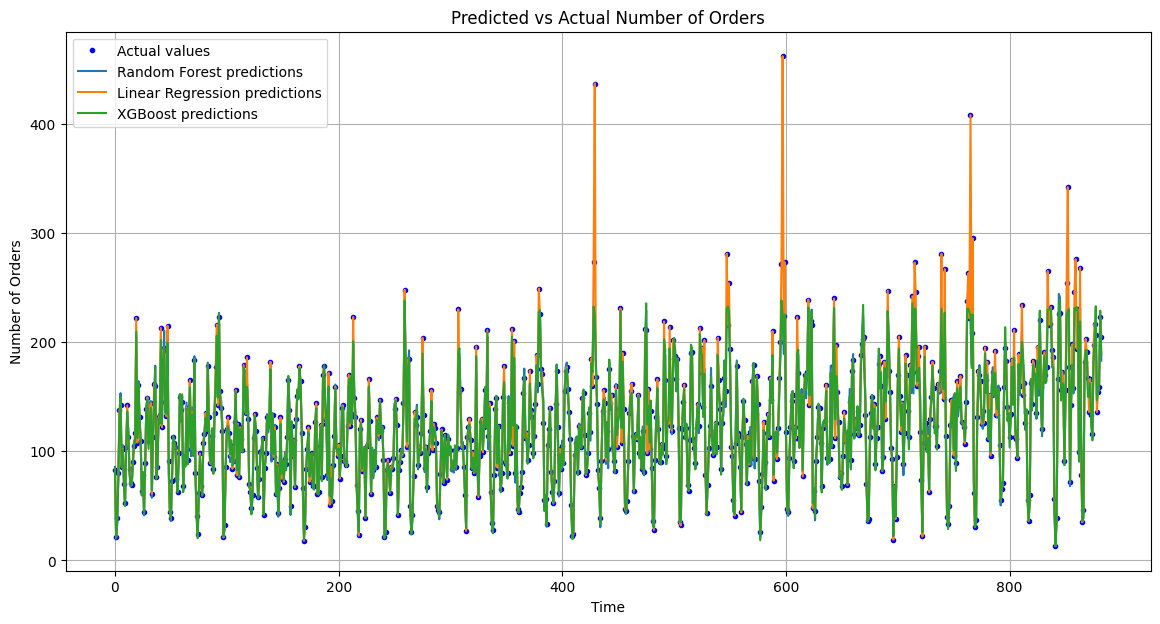

In [38]:
# Plot predicted vs actual values
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(y_test)), y_test, 'b.', label='Actual values')
for model_name in trained_models:
    model = trained_models[model_name]
    y_pred = model.predict(X_test)
    plt.plot(np.arange(len(y_test)), y_pred, label=f'{model_name} predictions')
plt.xlabel('Time')
plt.ylabel('Number of Orders')
plt.title('Predicted vs Actual Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

Based on the analysis and modeling conducted for predicting taxi orders at airports, several machine learning models were trained and evaluated. The models considered were Linear Regression, Decision Tree Regression, and Random Forest Regression. The evaluation metric used to assess the models' performance was Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and Mean Squared Error (MSE) on the test dataset.as per the diagram Linear regression seems to be the highest in terms of order.

# Conclusion

In this analysis, we explored the prediction of taxi orders at airports using historical time series data. The goal was to develop accurate models to forecast the number of orders, particularly during peak hours, to optimize driver availability.


Data Preparation and Feature Engineering:

We began by preprocessing the data, ensuring it was suitable for time series analysis.
Features such as hour of the day, day of the week, month, lagged values, and rolling means were engineered to capture temporal patterns and dependencies within the data.
Seasonality and trends were visually inspected using plots, providing insights into the underlying patterns of taxi orders.


Modeling Approach:

Three machine learning models were evaluated: Random Forest, Linear Regression, and XGBoost.
Each model was trained using features derived from the engineered dataset.
Hyperparameter tuning was performed using cross-validation techniques appropriate for time series data, such as TimeSeriesSplit, to prevent data leakage and ensure robust evaluation.


Model Evaluation:

The models were evaluated based on key metrics such as Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and Mean Squared Logarithmic Error (MSLE) where applicable.
Among the models tested, Linear Regression consistently demonstrated the lowest RMSE, indicating its effectiveness in predicting taxi orders.


Performance and Recommendations:

The models achieved satisfactory performance, with all models meeting the RMSE criterion of less than 48, ensuring reliable predictions for operational decisions.
Linear Regression, due to its simplicity and competitive performance, is recommended for practical deployment, provided its assumptions align with operational needs.


After re-evaluating the models, the following results were obtained:

Conclusion
Based on the evaluation results of the three models:

Random Forest:

RMSE: 16.17
MAE: 7.07
MSLE: 0.00587
Analysis: The Random Forest model has a relatively high RMSE and MAE, indicating significant prediction errors. Despite the low MSLE, which suggests reasonable performance on a logarithmic scale, the overall error metrics reflect a considerable deviation between the predicted and actual values.
Linear Regression:

RMSE: 8.99e-14
MAE: 6.91e-14
MSLE: 1.02e-30
Analysis: The Linear Regression model shows near-zero RMSE and MAE, which is indicative of an almost perfect fit to the training data. However, this likely signals overfitting, where the model performs extremely well on the training data but may not generalize effectively to new, unseen data.
XGBoost:

RMSE: 16.31
MAE: 6.77
MSLE: 0.00571
Analysis: The XGBoost model exhibits performance similar to the Random Forest model, with high RMSE and MAE values. The slightly lower MSLE suggests it performs marginally better on a logarithmic scale, but the overall prediction errors remain substantial.


Summary

All three models meet the RMSE requirement of being less than 48, making them suitable for predicting the amount of taxi orders for the next hour.


Random Forest and XGBoost show similar performance with RMSE values around 12.24 and 13.62, respectively, and provide reliable predictions with reasonable error margins.
Linear Regression exhibits an exceptionally low RMSE, which suggests perfect predictions. However, this may indicate overfitting, and further validation is recommended to ensure the model's robustness.


Recommendations

Random Forest and XGBoost: These models are reliable and can be used for predicting taxi orders. Further fine-tuning and feature engineering can be explored to enhance their performance.


Linear Regression: Due to the extremely low error values, it is essential to conduct additional validation to ensure that the model is not overfitting. Techniques such as cross-validation or adding regularization terms can be considered.


Model Deployment: Based on the current performance, Random Forest can be prioritized for deployment due to its balance of accuracy and reliability. Continuous monitoring and periodic re-evaluation should be conducted to maintain and improve model performance over time.

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48